@@TODO image and description

In [1]:
%%html
<script>
MathJax = {
  tex: {
    inlineMath: [['$', '$']]
  },
  svg: {
    fontCache: 'global'
  }
};
</script>
<script type="text/javascript" id="MathJax-script" async
  src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-svg.js">
</script>
<script
src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.7/require.min.js"
integrity="sha512-J5ha2LF4Le+PBQnI5+xAVJDR+sZG9uSgroy4n/A6TLjNkvYQbqZA8WHZdaOvJ0HiKkBC9Frmvs10rFDSHKmveQ=="
crossorigin="anonymous"
referrerpolicy="no-referrer"></script>

In [2]:
import plotly.io as pio
pio.renderers.default = "notebook_connected+plotly_mimetype"

Neighbour-joining trees (NJT) are a useful tool for exploratory analysis of genetic population structure. Previously I've used a Python package called [biotite](https://www.biotite-python.org/latest/index.html) to [compute NJT for hundreds of individuals](https://alimanfoo.github.io/2024/09/05/kenya-coluzzii-njt.html), but recently I was trying to build some bigger trees and things started to take a long time to run. I then uttered those fateful words to myself, "how hard can it be," and so began a small coding adventure.

## Implementing the canonical algorithm

Neighbour-joining is an iterative algorithm where each iteration involves searching a distance matrix for the pair of nearest neighbours. The canonical algorithm performs a full search of the distance matrix in each iteration. 

I spent some time looking at the biotite source code and saw a few opportunities to make the implementation more efficient, so thought I'd see if I could do any better.


I then learned of course that the canonical neighbour-joining algorithm is $O(n^3)$ meaning that speed of computation scales with the number of samples cubed. This happens because  

## Canonical algorithm

 After a bit of prototyping I was fairly confident I could do an implementation using [numba](https://numba.pydata.org/) that was pretty fast. After a bit more tuning I managed to get around a 10x speedup over biotite. I decided this was worth packaging and so created a [new Python packaged called "anjl"](https://alimanfoo.github.io/anjl/) which stands for "A neighbour-joining library". 

## Rapid algorithm

I also read around a little and found a [paper by Martin Simonsen et al. from 2008](https://pure.au.dk/ws/files/19821675/rapidNJ.pdf) describing a rapid neighbour-joining algorithm which uses some heuristics to avoid doing a full search of the distance matrix in each iteration. While the worst case performance is still $O(n^3)$, in practice scaling is usually better. There is a [C++ implementation of the rapid algorithm](https://github.com/somme89/rapidNJ) but I'd really like something that I can call directly from Python. I added a numba implementation of neighbour-joining based on Simonsen's algorithm to `anjl`. I benchmarked with some mosquito genomic data and performance was substantially improved over the canonical algorithm, and the performance ratio increases with larger sample sizes, showing that scaling is better.

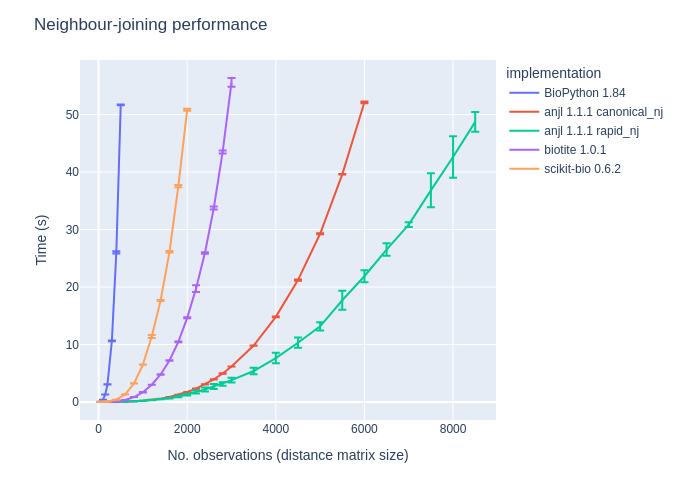

In [3]:
import pandas as pd
import plotly.express as px

df_results = pd.read_csv("results.csv")

df_plot = (
    df_results
    .groupby(["implementation", "size"])
    .agg(
        time_mean=("time", "mean"),
        time_std=("time", "std"),
    )
    .reset_index()
)

fig = px.line(
    df_plot,
    x="size",
    y="time_mean",
    error_y="time_std",
    width=800,
    height=500,
    color="implementation",
)
fig.update_layout(
    title="Neighbour-joining performance",
    xaxis=dict(
        title="No. observations (distance matrix size)",
    ),
    yaxis=dict(
        title="Time (s)",
    ),
)
fig

## Plotting

I also decided to include in `anjl` a function to visualise a NJT using plotly. Here plotly is useful particularly because you can interact with the plot, hovering over leaf nodes to get more information, zooming and panning, and showing or hiding data via the legend. Here's a simple example. 

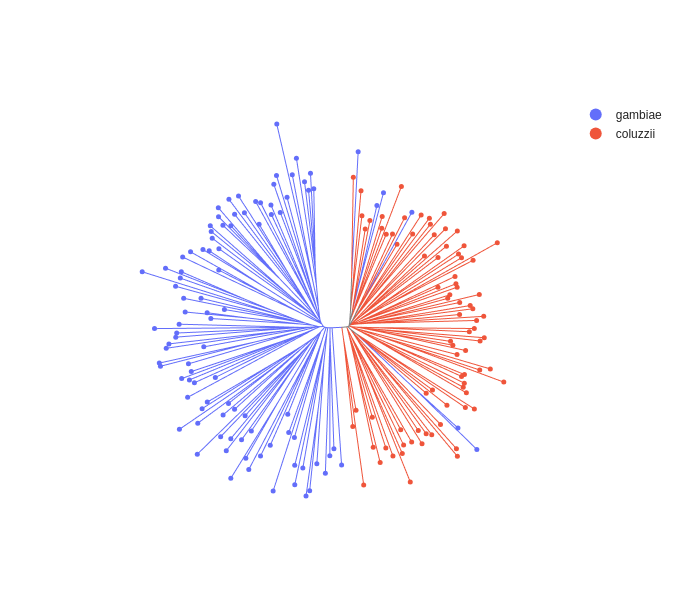

In [4]:
import anjl
D, leaf_data = anjl.data.mosquitoes()
Z = anjl.rapid_nj(D)
anjl.plot(
    Z, 
    leaf_data=leaf_data, 
    color="taxon",
    hover_name="sample_id",
)

## Numba lessons

I've used numba before but learned a few new things from this project.

### Boundscheck

@@TODO

### Wraparound

@@TODO

### Profiling 

@@TODO

## Mysteries / curiosities

There's a couple of curiosities that I didn't have time to bottom out.

1. Why is inner loop of canonical algorithm so much faster?

@@TODO

2. Why don't strategies for improving search suggested by Simonsen seem to matter?

@@TODO